# Course 4, Week 2 Lesson 2

Single Layer Neural Network to do Linear Regression forecasting.

* [Google Colab Notebook](https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%202.ipynb)

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


In [3]:
""" Define functions and constants to create our synthetic time series data """
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)


In [4]:
""" Split the time series into training and validation sets """
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
""" Set windowing constants and a reusable function that creates windowed datasets """
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
""" Create the windowed dataset """
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float32, tf.float32)>


In [7]:
""" Define, compile and fit model """
layer_0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([layer_0])

model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
)
model.fit(dataset, epochs=100, verbose=0) # verbose 0 means no output from training

print('layer weights {}'.format(layer_0.get_weights()))

layer weights [array([[-0.00534291],
       [-0.10981013],
       [ 0.10362003],
       [ 0.01175685],
       [ 0.05622044],
       [-0.03130407],
       [-0.03583463],
       [ 0.02841029],
       [-0.07778394],
       [ 0.04280171],
       [ 0.02564909],
       [ 0.00146412],
       [-0.01990039],
       [ 0.0691517 ],
       [-0.02268541],
       [ 0.02441411],
       [ 0.02785122],
       [ 0.21043615],
       [ 0.24163789],
       [ 0.4613412 ]], dtype=float32), array([0.01685796], dtype=float32)]


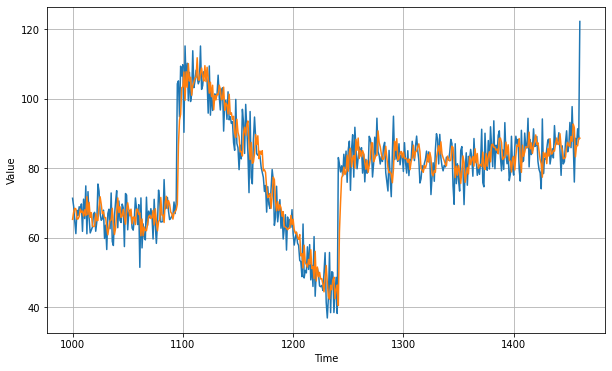

In [9]:
""" Predict on the given Time Series and chart the predicted (orange) against the actual (blue) """
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
""" What was the Mean Absolute Error (MSE)? """
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.934754